In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

In [13]:
raw_df = pd.read_csv("train_1.csv", nrows=1000)

In [14]:
df = raw_df.melt(id_vars='Page', var_name='date', value_name='views')

df['date'] = pd.to_datetime(df['date'])

df['views'] = pd.to_numeric(df['views'], errors='coerce')

df['views'] = df['views'].fillna(0)

df = df[np.isfinite(df['views']) & (df['views'] >= 0)]


df = df.sort_values(by=['Page', 'date']).reset_index(drop=True)


print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550000 entries, 0 to 549999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Page    550000 non-null  object        
 1   date    550000 non-null  datetime64[ns]
 2   views   550000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 12.6+ MB
None
                                      Page       date  views
0  100毛_zh.wikipedia.org_all-access_spider 2015-07-01   14.0
1  100毛_zh.wikipedia.org_all-access_spider 2015-07-02    6.0
2  100毛_zh.wikipedia.org_all-access_spider 2015-07-03   14.0
3  100毛_zh.wikipedia.org_all-access_spider 2015-07-04   10.0
4  100毛_zh.wikipedia.org_all-access_spider 2015-07-05    5.0


In [ ]:
# Group by Page to calculate stats
page_stats = df.groupby('Page')['views'].agg(
    total_points='count',
    non_zero_points=lambda x: (x > 0).sum(),
    zero_ratio=lambda x: (x == 0).mean(),
    mean_views='mean'
).reset_index()

filtered_pages = page_stats[
    (page_stats['total_points'] >= 500) &
    (page_stats['non_zero_points'] >= 300) &
    (page_stats['zero_ratio'] < 0.8)
]['Page']

filtered_df = df[df['Page'].isin(filtered_pages)]
print(f"Pages before filtering: {df['Page'].nunique()}")
print(f"Pages after filtering: {filtered_df['Page'].nunique()}")


Pages before filtering: 1000
Pages after filtering: 964


In [16]:
def regularize_page(page_df):
    page_df = page_df.set_index('date').asfreq('D')
    page_df['views'] = page_df['views'].fillna(0)
    page_df['Page'] = page_df['Page'].iloc[0]
    return page_df.reset_index()

clean_df = filtered_df.groupby('Page', group_keys=False).apply(regularize_page)

print("Final cleaned shape:", clean_df.shape)


Final cleaned shape: (530200, 3)


In [17]:
clean_df['log_views'] = np.log1p(clean_df['views'])


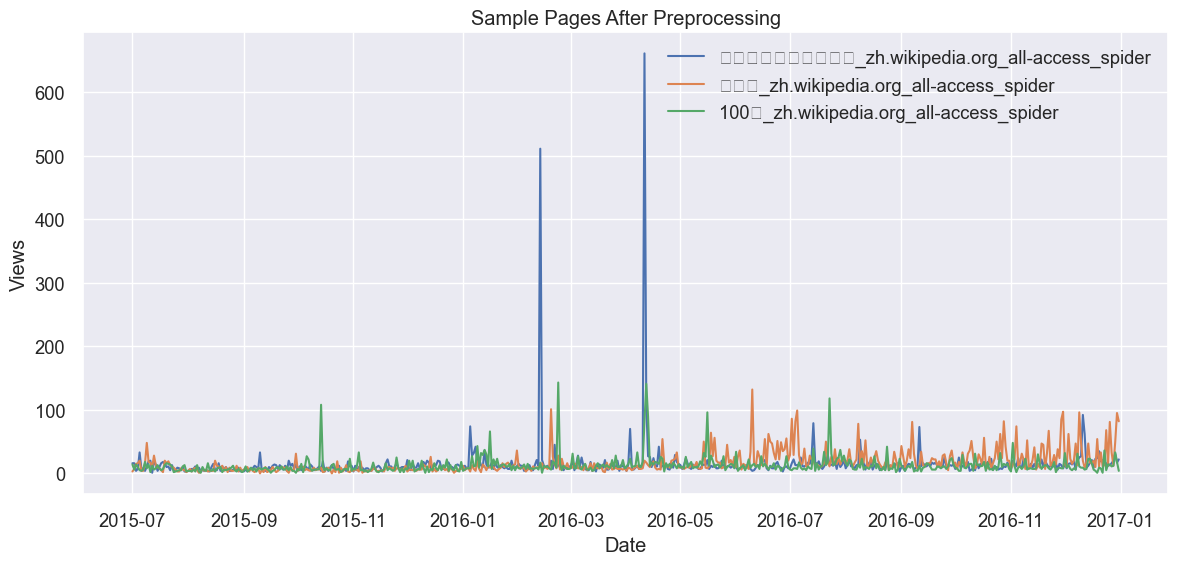

In [19]:
sample_pages = random.sample(clean_df['Page'].unique().tolist(), 3)

plt.figure(figsize=(14, 6))
for p in sample_pages:
    sub = clean_df[clean_df['Page'] == p]
    plt.plot(sub['date'], sub['views'], label=p)

plt.title("Sample Pages After Preprocessing")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.show()